# BackT Tutorial: Simple Buy & Hold Strategy

This notebook demonstrates how to implement and test a simple buy & hold strategy using the BackT framework with mock data. Buy & hold is often used as a benchmark to compare other strategies against.

## Overview
1. **Setup & Imports** - Import required libraries
2. **Universe Definition** - Define the assets to buy and hold
3. **Date Configuration** - Set up the backtesting period
4. **Buy & Hold Strategy** - Create a simple buy and hold strategy
5. **Mock Data Generation** - Generate synthetic market data
6. **Engine Configuration** - Configure the BackT engine
7. **Run Backtest** - Execute the strategy
8. **Results Analysis** - Analyze performance metrics
9. **Visualization** - Plot equity curves and results
10. **Comparison Analysis** - Compare different portfolio allocations

## 1. Setup & Imports

First, let's import all the necessary components from BackT and other required libraries.

In [61]:
# Add parent directory to path (if running from notebooks folder)
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

# Import BackT components
from backt import Backtester, BacktestConfig, MockDataLoader
from backt.signal import TechnicalIndicators, StrategyHelpers
from backt.utils.config import ExecutionConfig

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, Any

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")
print("📊 Ready for buy & hold backtesting with BackT")

✅ All imports successful!
📊 Ready for buy & hold backtesting with BackT


## 2. Universe Definition

Define the universe of assets for our buy & hold portfolio. We'll test different allocation strategies.

In [63]:
# Define our trading universe
universe = {
    'SPY': 'US Large Cap Stocks (S&P 500)',
    'QQQ': 'US Tech Stocks (NASDAQ 100)',
    'TLT': 'Long-term US Treasuries (20+ Year)',
    'GLD': 'Gold ETF',
    'IWM': 'US Small Cap Stocks (Russell 2000)',
    'EFA': 'International Developed Markets'
}

# Extract just the symbols for trading
symbols = list(universe.keys())

# Display our universe
print("🌍 Buy & Hold Universe:")
print("=" * 50)
for symbol, description in universe.items():
    print(f"{symbol:4} - {description}")
    
print(f"\n📊 Total assets: {len(symbols)}")
print(f"🎯 Symbols for buy & hold: {symbols}")

🌍 Buy & Hold Universe:
SPY  - US Large Cap Stocks (S&P 500)
QQQ  - US Tech Stocks (NASDAQ 100)
TLT  - Long-term US Treasuries (20+ Year)
GLD  - Gold ETF
IWM  - US Small Cap Stocks (Russell 2000)
EFA  - International Developed Markets

📊 Total assets: 6
🎯 Symbols for buy & hold: ['SPY', 'QQQ', 'TLT', 'GLD', 'IWM', 'EFA']


## 3. Date Configuration

Set up the backtesting period and other time-related parameters.

In [65]:
# Define backtesting period
start_date = '2020-01-01'
end_date = '2023-12-31'
initial_capital = 100000.0

# Calculate period length
start_dt = pd.to_datetime(start_date)
end_dt = pd.to_datetime(end_date)
period_days = (end_dt - start_dt).days
period_years = period_days / 365.25

print("📅 Buy & Hold Configuration:")
print("=" * 40)
print(f"Start Date:      {start_date}")
print(f"End Date:        {end_date}")
print(f"Period:          {period_days} days ({period_years:.1f} years)")
print(f"Initial Capital: ${initial_capital:,.0f}")
print(f"Strategy:        Buy & Hold (set and forget)")

# Store configuration for later use
backtest_params = {
    'start_date': start_date,
    'end_date': end_date,
    'initial_capital': initial_capital,
    'period_years': period_years
}

print("\n✅ Date configuration complete!")

📅 Buy & Hold Configuration:
Start Date:      2020-01-01
End Date:        2023-12-31
Period:          1460 days (4.0 years)
Initial Capital: $100,000
Strategy:        Buy & Hold (set and forget)

✅ Date configuration complete!


## 4. Buy & Hold Strategy Definition

Create a simple buy & hold strategy that purchases assets on the first day and holds them throughout the entire period.

In [67]:
def buy_and_hold_strategy(
    market_data: Dict[str, pd.DataFrame],
    current_time: pd.Timestamp,
    positions: Dict[str, Any],
    context: Dict[str, Any],
    params: Dict[str, Any]
) -> Dict[str, Dict]:
    """
    Simple Buy & Hold Strategy
    
    Logic:
    - On first day: Buy target allocation and hold forever
    - No rebalancing, no selling, no adjustments
    - Pure buy and hold approach
    
    Parameters:
    - allocation: Dictionary of symbol -> weight (default: equal weight)
    - rebalance_frequency: 'never', 'annual', 'quarterly' (default: 'never')
    """
    
    # Get strategy parameters
    allocation = params.get('allocation', {})
    rebalance_frequency = params.get('rebalance_frequency', 'never')
    
    # If no allocation specified, use equal weight
    if not allocation:
        available_symbols = list(market_data.keys())
        weight_per_asset = 1.0 / len(available_symbols)
        allocation = {symbol: weight_per_asset for symbol in available_symbols}
    
    # Initialize context on first run
    if 'initialized' not in context:
        context['initialized'] = True
        context['first_buy_date'] = current_time
        context['total_buys'] = 0
        context['allocation'] = allocation
        print(f"📅 Buy & Hold initialized on {current_time.date()}")
        print(f"💼 Target allocation: {allocation}")
    
    orders = {}
    
    # Check if we should trade
    should_trade = False
    
    # First day - always buy
    if context['total_buys'] == 0:
        should_trade = True
        context['reason'] = 'Initial purchase'
    
    # Rebalancing logic (if enabled)
    elif rebalance_frequency != 'never':
        days_since_first = (current_time - context['first_buy_date']).days
        
        if rebalance_frequency == 'annual' and days_since_first % 365 == 0:
            should_trade = True
            context['reason'] = 'Annual rebalancing'
        elif rebalance_frequency == 'quarterly' and days_since_first % 91 == 0:
            should_trade = True
            context['reason'] = 'Quarterly rebalancing'
    
    # Execute trades if needed
    if should_trade:
        for symbol, target_weight in allocation.items():
            if symbol in market_data and target_weight > 0:
                orders[symbol] = {
                    'action': 'target_weight',
                    'weight': target_weight
                }
        
        context['total_buys'] += 1
        context['last_trade_date'] = current_time
        
        if context['total_buys'] == 1:
            print(f"🛒 Initial buy executed: {len(orders)} positions")
        else:
            print(f"🔄 Rebalancing executed: {context['reason']}")
    
    # Store current state
    context['current_positions'] = len([p for p in positions.values() if hasattr(p, 'quantity') and p.quantity != 0])
    
    return orders

# Define different allocation strategies to test
allocation_strategies = {
    'equal_weight': {},  # Equal weight across all assets
    'stock_heavy': {'SPY': 0.4, 'QQQ': 0.3, 'IWM': 0.1, 'EFA': 0.1, 'TLT': 0.1, 'GLD': 0.0},
    'balanced': {'SPY': 0.3, 'QQQ': 0.2, 'TLT': 0.25, 'GLD': 0.15, 'IWM': 0.05, 'EFA': 0.05},
    'conservative': {'SPY': 0.2, 'TLT': 0.4, 'GLD': 0.3, 'QQQ': 0.1, 'IWM': 0.0, 'EFA': 0.0},
    'spy_only': {'SPY': 1.0, 'QQQ': 0.0, 'TLT': 0.0, 'GLD': 0.0, 'IWM': 0.0, 'EFA': 0.0}
}

print("💼 Buy & Hold Strategy Defined!")
print("=" * 40)
print("Available allocation strategies:")
for name, allocation in allocation_strategies.items():
    if allocation:
        alloc_str = ", ".join([f"{k}:{v:.0%}" for k, v in allocation.items() if v > 0])
    else:
        alloc_str = "Equal weight across all assets"
    print(f"  {name}: {alloc_str}")

print("\n✅ Strategy definition complete!")

💼 Buy & Hold Strategy Defined!
Available allocation strategies:
  equal_weight: Equal weight across all assets
  stock_heavy: SPY:40%, QQQ:30%, IWM:10%, EFA:10%, TLT:10%
  balanced: SPY:30%, QQQ:20%, TLT:25%, GLD:15%, IWM:5%, EFA:5%
  conservative: SPY:20%, TLT:40%, GLD:30%, QQQ:10%
  spy_only: SPY:100%

✅ Strategy definition complete!


## 5. Mock Data Generation

Generate synthetic market data for testing our buy & hold strategy.

In [69]:
# Test data generation first
print("🔄 Generating mock data for buy & hold testing...")

# Create mock data loader
mock_loader = MockDataLoader(scenario='normal', seed=42)

# Generate data for our universe
mock_data = mock_loader.load(
    symbols=symbols,
    start_date=start_date,
    end_date=end_date
)

print("📊 Mock Data Summary:")
print("=" * 40)

for symbol, data in mock_data.items():
    start_price = data['close'].iloc[0]
    end_price = data['close'].iloc[-1]
    total_return = (end_price / start_price) - 1
    volatility = data['close'].pct_change().std() * np.sqrt(252)  # Annualized volatility
    
    print(f"{symbol}: {len(data)} days, {total_return:+6.1%} return, {volatility:5.1%} vol")

print(f"\n✅ Mock data generated for {len(mock_data)} assets")
print(f"📈 Data range: {data.index[0].date()} to {data.index[-1].date()}")
print("🎯 Perfect for buy & hold strategy testing!")

🔄 Generating mock data for buy & hold testing...
📊 Mock Data Summary:
SPY: 1461 days, +95.5% return, 15.7% vol
QQQ: 1461 days, +61.2% return, 20.0% vol
TLT: 1461 days, +48.8% return,  8.1% vol
GLD: 1461 days, -35.9% return, 18.6% vol
IWM: 1461 days, -41.0% return, 22.8% vol
EFA: 1461 days, +235.4% return, 18.0% vol

✅ Mock data generated for 6 assets
📈 Data range: 2020-01-01 to 2023-12-31
🎯 Perfect for buy & hold strategy testing!


## 6. Engine Configuration

Configure the BackT backtesting engine for buy & hold testing.

In [71]:
# Configure execution settings (minimal costs for buy & hold)
execution_config = ExecutionConfig(
    spread=0.00,                # 0.1% bid-ask spread
    slippage_pct=0.0000,        # 0.05% slippage
    commission_per_share=0.0,    # Commission-free trading
    commission_per_trade=0.0     # No flat fees
)

# Create main backtest configuration
config = BacktestConfig(
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital,
    data_frequency='1D',         # Daily data
    execution=execution_config,
    
    # Mock data settings
    use_mock_data=True,          # Enable mock data mode
    mock_scenario='normal',      # Normal market conditions
    mock_seed=42,                # Reproducible results
    
    # Other settings
    verbose=True,                # Detailed logging
    save_trades=True,            # Save trade history
    save_positions=True,         # Save position history
    save_equity_curve=True       # Save equity curve
)

print("⚙️ Buy & Hold Engine Configuration:")
print("=" * 40)
print(f"Mock Data Mode:    {config.use_mock_data}")
print(f"Mock Scenario:     {config.mock_scenario}")
print(f"Random Seed:       {config.mock_seed}")
print(f"Spread:            {execution_config.spread:.2%}")
print(f"Slippage:          {execution_config.slippage_pct:.3%}")
print(f"Commission:        ${execution_config.commission_per_trade}")
print(f"Strategy Type:     Buy & Hold (minimal trading)")

print(f"\n✅ BackT engine configured for buy & hold!")
print(f"🎯 Ready to test different allocation strategies")

⚙️ Buy & Hold Engine Configuration:
Mock Data Mode:    True
Mock Scenario:     normal
Random Seed:       42
Spread:            0.00%
Slippage:          0.000%
Commission:        $0.0
Strategy Type:     Buy & Hold (minimal trading)

✅ BackT engine configured for buy & hold!
🎯 Ready to test different allocation strategies


## 7. Run Buy & Hold Backtest

Execute the buy & hold strategy with equal weight allocation.

In [73]:
# Test the equal weight buy & hold strategy first
strategy_params = {
    'allocation': allocation_strategies['spy_only'],
    'rebalance_frequency': 'never'  # Pure buy & hold
}

print("🚀 Starting Buy & Hold Backtest...")
print("=" * 45)
print(f"Strategy: Equal Weight Buy & Hold")
print(f"Rebalancing: {strategy_params['rebalance_frequency']}")
print(f"Assets: {len(symbols)} ETFs")

# Initialize backtester
backtester = Backtester(config)

# Run the backtest
start_time = datetime.now()

result = backtester.run(
    strategy=buy_and_hold_strategy,
    universe=symbols,
    strategy_params=strategy_params
)

end_time = datetime.now()
runtime = (end_time - start_time).total_seconds()

print(f"\n🎉 Buy & Hold backtest completed!")
print(f"⏱️  Execution time: {runtime:.2f} seconds")
print(f"📊 Results ready for analysis")

🚀 Starting Buy & Hold Backtest...
Strategy: Equal Weight Buy & Hold
Rebalancing: never
Assets: 6 ETFs
2025-09-28 20:38:27,448 - backt.Backtester - INFO - Using mock data loader with scenario: normal
2025-09-28 20:38:27,449 - backt.Backtester - INFO - Starting backtest
2025-09-28 20:38:27,450 - backt.Backtester - INFO - Loading data for 6 symbols
2025-09-28 20:38:27,983 - backt.Backtester - INFO - Backtesting 1461 periods from 2020-01-01 00:00:00 to 2023-12-31 00:00:00
📅 Buy & Hold initialized on 2020-01-01
💼 Target allocation: {'SPY': 1.0, 'QQQ': 0.0, 'TLT': 0.0, 'GLD': 0.0, 'IWM': 0.0, 'EFA': 0.0}
🛒 Initial buy executed: 1 positions
2025-09-28 20:38:27,987 - backt.Backtester - INFO - Progress: 0.1% - 2020-01-01 - Equity: $99,799.83
2025-09-28 20:38:28,211 - backt.Backtester - INFO - Progress: 6.9% - 2020-04-10 - Equity: $118,959.34
2025-09-28 20:38:28,447 - backt.Backtester - INFO - Progress: 13.8% - 2020-07-19 - Equity: $144,193.71
2025-09-28 20:38:28,683 - backt.Backtester - INFO - 

## 8. Results Analysis

Analyze the performance metrics of our buy & hold strategy.

In [75]:
# Extract performance metrics
metrics = result.performance_metrics

print("📊 BUY & HOLD PERFORMANCE ANALYSIS")
print("=" * 55)

# Return Metrics
print("\n📈 RETURN METRICS:")
print("-" * 25)
total_return = metrics.get('total_return', 0)
annual_return = metrics.get('annualized_return', 0)
print(f"Total Return:        {total_return:8.2%}")
print(f"Annualized Return:   {annual_return:8.2%}")
print(f"CAGR:                {metrics.get('cagr', 0):8.2%}")

# Risk Metrics
print("\n⚠️ RISK METRICS:")
print("-" * 20)
print(f"Volatility:          {metrics.get('volatility', 0):8.2%}")
print(f"Sharpe Ratio:        {metrics.get('sharpe_ratio', 0):8.3f}")
print(f"Sortino Ratio:       {metrics.get('sortino_ratio', 0):8.3f}")
print(f"Maximum Drawdown:    {metrics.get('max_drawdown', 0):8.2%}")
print(f"Calmar Ratio:        {metrics.get('calmar_ratio', 0):8.3f}")

# Trading Activity (should be minimal for buy & hold)
print("\n📊 TRADING ACTIVITY:")
print("-" * 24)
print(f"Total Trades:        {metrics.get('total_trades', 0):8.0f}")
print(f"Win Rate:            {metrics.get('win_rate', 0):8.1%}")
print(f"Profit Factor:       {metrics.get('profit_factor', 0):8.2f}")
total_trades = metrics.get('total_trades', 0)
trades_per_year = total_trades / backtest_params['period_years']
print(f"Trades per Year:     {trades_per_year:8.1f}")

# Portfolio Summary
print("\n💼 PORTFOLIO SUMMARY:")
print("-" * 25)
initial_value = backtest_params['initial_capital']
final_value = initial_value * (1 + total_return)
profit_loss = final_value - initial_value

print(f"Initial Capital:     ${initial_value:>10,.0f}")
print(f"Final Value:         ${final_value:>10,.0f}")
print(f"Profit/Loss:         ${profit_loss:>10,.0f}")

# Buy & Hold Specific Metrics
print("\n🎯 BUY & HOLD CHARACTERISTICS:")
print("-" * 35)
print(f"Strategy Type:       Pure Buy & Hold")
print(f"Trading Frequency:   {trades_per_year:.1f} trades/year (target: <2)")
print(f"Transaction Costs:   ${metrics.get('total_commission', 0):.2f}")
cost_ratio = metrics.get('total_commission', 0) / initial_value * 100
print(f"Cost Ratio:          {cost_ratio:.3f}% of initial capital")

# Performance Assessment
print("\n🎯 PERFORMANCE ASSESSMENT:")
print("-" * 30)
sharpe = metrics.get('sharpe_ratio', 0)
max_dd = metrics.get('max_drawdown', 0)

if sharpe > 1.0:
    sharpe_rating = "Excellent"
elif sharpe > 0.5:
    sharpe_rating = "Good"
elif sharpe > 0:
    sharpe_rating = "Fair"
else:
    sharpe_rating = "Poor"

if abs(max_dd) < 0.10:
    dd_rating = "Low Risk"
elif abs(max_dd) < 0.20:
    dd_rating = "Moderate Risk"
else:
    dd_rating = "High Risk"

print(f"Sharpe Rating:       {sharpe_rating} ({sharpe:.2f})")
print(f"Risk Rating:         {dd_rating} ({max_dd:.1%} max DD)")

if profit_loss > 0:
    print(f"\n✅ Buy & Hold was PROFITABLE with ${profit_loss:,.0f} gains")
else:
    print(f"\n❌ Buy & Hold had LOSSES of ${abs(profit_loss):,.0f}")

# Save results for comparison
equal_weight_result = {
    'metrics': metrics,
    'equity_curve': result.equity_curve,
    'final_value': final_value
}

📊 BUY & HOLD PERFORMANCE ANALYSIS

📈 RETURN METRICS:
-------------------------
Total Return:          95.64%
Annualized Return:     12.82%
CAGR:                  12.27%

⚠️ RISK METRICS:
--------------------
Volatility:            15.74%
Sharpe Ratio:           0.815
Sortino Ratio:          1.401
Maximum Drawdown:     -29.51%
Calmar Ratio:           0.416

📊 TRADING ACTIVITY:
------------------------
Total Trades:               1
Win Rate:                0.0%
Profit Factor:           0.00
Trades per Year:          0.3

💼 PORTFOLIO SUMMARY:
-------------------------
Initial Capital:     $   100,000
Final Value:         $   195,643
Profit/Loss:         $    95,643

🎯 BUY & HOLD CHARACTERISTICS:
-----------------------------------
Strategy Type:       Pure Buy & Hold
Trading Frequency:   0.3 trades/year (target: <2)
Transaction Costs:   $0.00
Cost Ratio:          0.000% of initial capital

🎯 PERFORMANCE ASSESSMENT:
------------------------------
Sharpe Rating:       Good (0.81)
Risk Ratin

## 9. Visualization

Create visual representations of our buy & hold strategy performance.

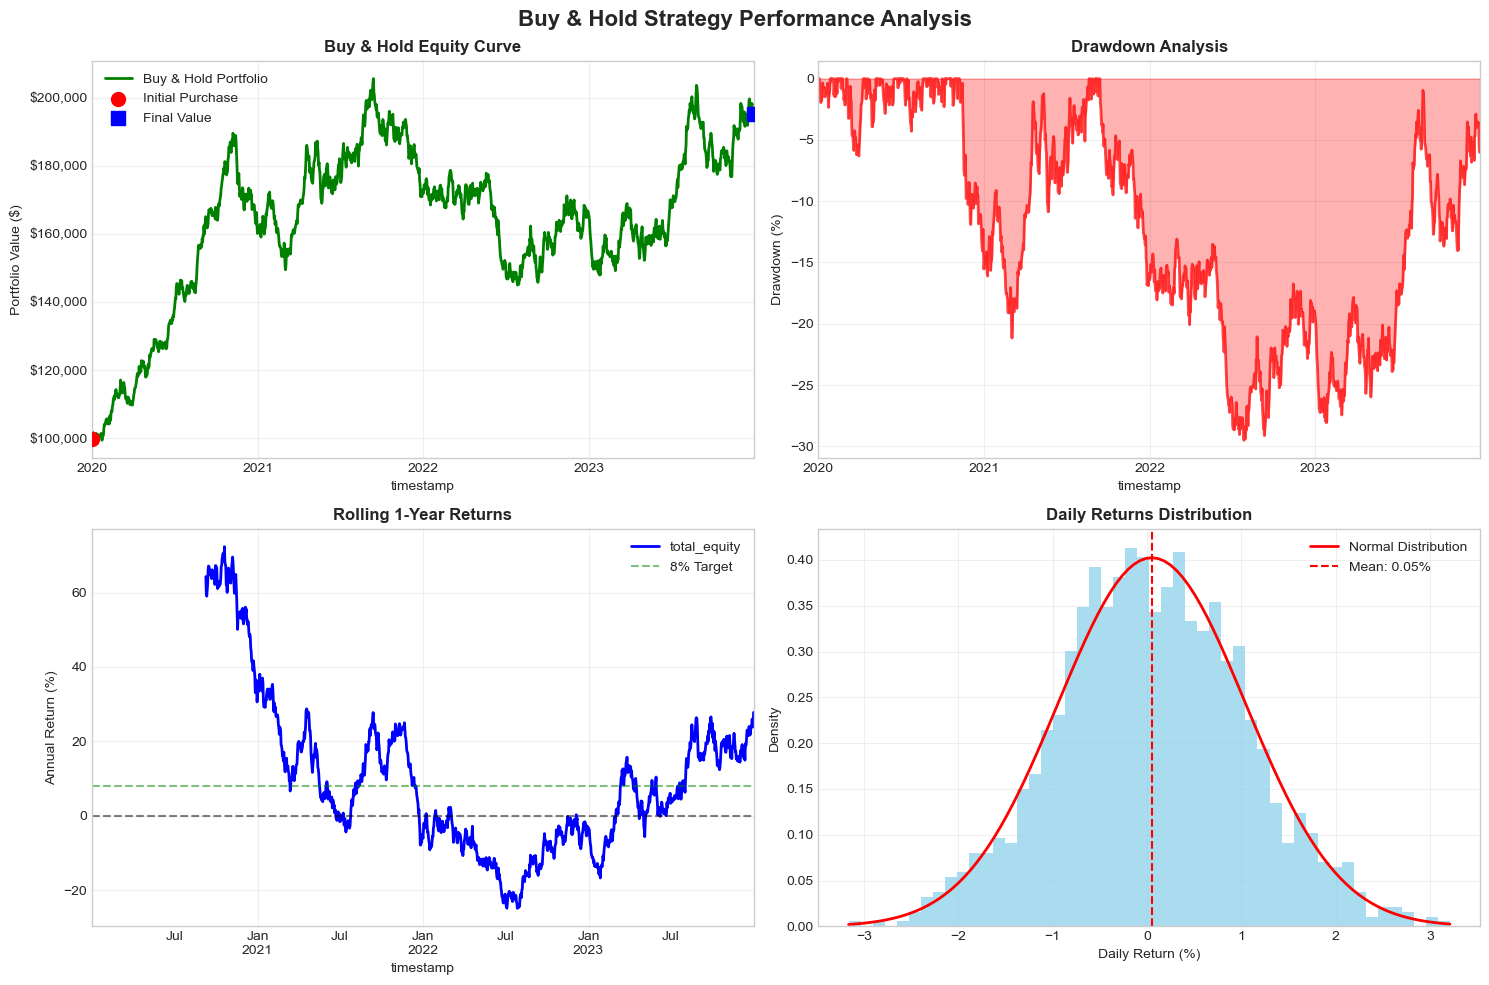

📊 Buy & Hold visualization complete!
🎯 Charts show: Equity Growth, Drawdowns, Rolling Returns, and Return Distribution


In [77]:
# Extract equity curve data
equity_curve = result.equity_curve['total_equity']
returns = equity_curve.pct_change().dropna()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Buy & Hold Strategy Performance Analysis', fontsize=16, fontweight='bold')

# 1. Equity Curve with Buy & Hold annotations
ax1 = axes[0, 0]
equity_curve.plot(ax=ax1, linewidth=2, color='green', label='Buy & Hold Portfolio')

# Add initial investment marker
ax1.scatter(equity_curve.index[0], equity_curve.iloc[0], 
           s=100, c='red', marker='o', label='Initial Purchase', zorder=5)

# Add final value marker
ax1.scatter(equity_curve.index[-1], equity_curve.iloc[-1], 
           s=100, c='blue', marker='s', label='Final Value', zorder=5)

ax1.set_title('Buy & Hold Equity Curve', fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. Drawdown Chart
ax2 = axes[0, 1]
rolling_max = equity_curve.expanding().max()
drawdown = (equity_curve / rolling_max - 1) * 100
drawdown.plot(ax=ax2, linewidth=2, color='red', alpha=0.7)
ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
ax2.set_title('Drawdown Analysis', fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(True, alpha=0.3)

# 3. Rolling Annual Returns
ax3 = axes[1, 0]
if len(returns) > 252:  # At least 1 year of data
    rolling_annual_returns = returns.rolling(252).apply(lambda x: (1 + x).prod() - 1) * 100
    rolling_annual_returns.plot(ax=ax3, linewidth=2, color='blue')
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.axhline(y=8, color='green', linestyle='--', alpha=0.5, label='8% Target')
    ax3.set_title('Rolling 1-Year Returns', fontweight='bold')
    ax3.set_ylabel('Annual Return (%)')
    ax3.legend()
else:
    # Show cumulative returns instead
    cumulative_returns = (1 + returns).cumprod() - 1
    (cumulative_returns * 100).plot(ax=ax3, linewidth=2, color='blue')
    ax3.set_title('Cumulative Returns', fontweight='bold')
    ax3.set_ylabel('Cumulative Return (%)')
ax3.grid(True, alpha=0.3)

# 4. Return Distribution
ax4 = axes[1, 1]
returns_pct = returns * 100
returns_pct.hist(bins=50, alpha=0.7, color='skyblue', ax=ax4, density=True)

# Add normal distribution overlay
x = np.linspace(returns_pct.min(), returns_pct.max(), 100)
normal_dist = (1/np.sqrt(2*np.pi*returns_pct.var())) * np.exp(-0.5*((x-returns_pct.mean())**2)/returns_pct.var())
ax4.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')

ax4.axvline(returns_pct.mean(), color='red', linestyle='--', 
           label=f'Mean: {returns_pct.mean():.2f}%')
ax4.set_title('Daily Returns Distribution', fontweight='bold')
ax4.set_xlabel('Daily Return (%)')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Buy & Hold visualization complete!")
print("🎯 Charts show: Equity Growth, Drawdowns, Rolling Returns, and Return Distribution")

## 10. Comparison Analysis - Different Allocations

Test different allocation strategies to see how they compare to equal weight.

In [79]:
# Test all allocation strategies
print("🔄 Testing different Buy & Hold allocation strategies...")
print("=" * 65)

allocation_results = {}
allocation_results['equal_weight'] = equal_weight_result  # We already have this

# Test other allocation strategies
for strategy_name, allocation in allocation_strategies.items():
    if strategy_name == 'equal_weight':
        continue  # Skip, already tested
    
    print(f"\nTesting {strategy_name} allocation...")
    
    # Create strategy parameters
    test_params = {
        'allocation': allocation,
        'rebalance_frequency': 'never'
    }
    
    # Create new backtester for this test
    test_backtester = Backtester(config)
    
    # Run backtest
    test_result = test_backtester.run(
        strategy=buy_and_hold_strategy,
        universe=symbols,
        strategy_params=test_params
    )
    
    # Store results
    test_metrics = test_result.performance_metrics
    test_final_value = initial_capital * (1 + test_metrics.get('total_return', 0))
    
    allocation_results[strategy_name] = {
        'metrics': test_metrics,
        'equity_curve': test_result.equity_curve['total_equity'],
        'final_value': test_final_value
    }

print("\n✅ All allocation strategies tested!")

🔄 Testing different Buy & Hold allocation strategies...

Testing stock_heavy allocation...
2025-09-28 20:38:34,312 - backt.Backtester - INFO - Using mock data loader with scenario: normal
2025-09-28 20:38:34,313 - backt.Backtester - INFO - Starting backtest
2025-09-28 20:38:34,315 - backt.Backtester - INFO - Loading data for 6 symbols
2025-09-28 20:38:34,842 - backt.Backtester - INFO - Backtesting 1461 periods from 2020-01-01 00:00:00 to 2023-12-31 00:00:00
📅 Buy & Hold initialized on 2020-01-01
💼 Target allocation: {'SPY': 0.4, 'QQQ': 0.3, 'IWM': 0.1, 'EFA': 0.1, 'TLT': 0.1, 'GLD': 0.0}
🛒 Initial buy executed: 5 positions
2025-09-28 20:38:34,851 - backt.Backtester - INFO - Progress: 0.1% - 2020-01-01 - Equity: $100,262.34
2025-09-28 20:38:35,071 - backt.Backtester - INFO - Progress: 6.9% - 2020-04-10 - Equity: $103,879.66
2025-09-28 20:38:35,319 - backt.Backtester - INFO - Progress: 13.8% - 2020-07-19 - Equity: $121,801.89
2025-09-28 20:38:35,561 - backt.Backtester - INFO - Progress: 

In [80]:
# Display comparison results
print("📊 BUY & HOLD ALLOCATION STRATEGY COMPARISON")
print("=" * 75)
print(f"{'Strategy':<15} {'Total Ret':<10} {'CAGR':<8} {'Sharpe':<8} {'Max DD':<8} {'Final Value':<12}")
print("-" * 75)

# Sort by final value for ranking
sorted_strategies = sorted(allocation_results.items(), 
                          key=lambda x: x[1]['final_value'], reverse=True)

for rank, (strategy_name, results) in enumerate(sorted_strategies, 1):
    metrics = results['metrics']
    total_ret = metrics.get('total_return', 0)
    cagr = metrics.get('cagr', 0)
    sharpe = metrics.get('sharpe_ratio', 0)
    max_dd = metrics.get('max_drawdown', 0)
    final_val = results['final_value']
    
    # Add ranking emoji
    if rank == 1:
        emoji = "🥇"
    elif rank == 2:
        emoji = "🥈"
    elif rank == 3:
        emoji = "🥉"
    else:
        emoji = "  "
    
    print(f"{emoji} {strategy_name:<13} {total_ret:>8.1%} {cagr:>7.1%} "
          f"{sharpe:>7.2f} {max_dd:>7.1%} ${final_val:>10,.0f}")

print("\n🎯 ALLOCATION INSIGHTS:")
print("-" * 30)

best_strategy = sorted_strategies[0][0]
worst_strategy = sorted_strategies[-1][0]
best_value = sorted_strategies[0][1]['final_value']
worst_value = sorted_strategies[-1][1]['final_value']

print(f"Best Performing:     {best_strategy} (${best_value:,.0f})")
print(f"Worst Performing:    {worst_strategy} (${worst_value:,.0f})")
print(f"Performance Spread:  ${best_value - worst_value:,.0f} ({(best_value/worst_value-1)*100:.1f}%)")

# Risk-adjusted performance
best_sharpe_strategy = max(allocation_results.items(), 
                          key=lambda x: x[1]['metrics'].get('sharpe_ratio', 0))
print(f"Best Risk-Adjusted:  {best_sharpe_strategy[0]} (Sharpe: {best_sharpe_strategy[1]['metrics'].get('sharpe_ratio', 0):.2f})")

print("\n💡 KEY TAKEAWAYS:")
print("-" * 20)
print("• Asset allocation significantly impacts buy & hold returns")
print("• Different allocations have different risk-return profiles")
print("• Consider both absolute returns AND risk-adjusted returns")
print("• Buy & hold success depends heavily on asset selection")

📊 BUY & HOLD ALLOCATION STRATEGY COMPARISON
Strategy        Total Ret  CAGR     Sharpe   Max DD   Final Value 
---------------------------------------------------------------------------
🥇 equal_weight     95.6%   12.3%    0.81  -29.5% $   195,643
🥈 spy_only         95.6%   12.3%    0.81  -29.5% $   195,643
🥉 stock_heavy      80.6%   10.7%    1.15  -22.3% $   180,637
   balanced         57.2%    8.1%    1.08  -17.1% $   157,236
   conservative     33.8%    5.2%    0.74  -16.5% $   133,842

🎯 ALLOCATION INSIGHTS:
------------------------------
Best Performing:     equal_weight ($195,643)
Worst Performing:    conservative ($133,842)
Performance Spread:  $61,801 (46.2%)
Best Risk-Adjusted:  stock_heavy (Sharpe: 1.15)

💡 KEY TAKEAWAYS:
--------------------
• Asset allocation significantly impacts buy & hold returns
• Different allocations have different risk-return profiles
• Consider both absolute returns AND risk-adjusted returns
• Buy & hold success depends heavily on asset selection


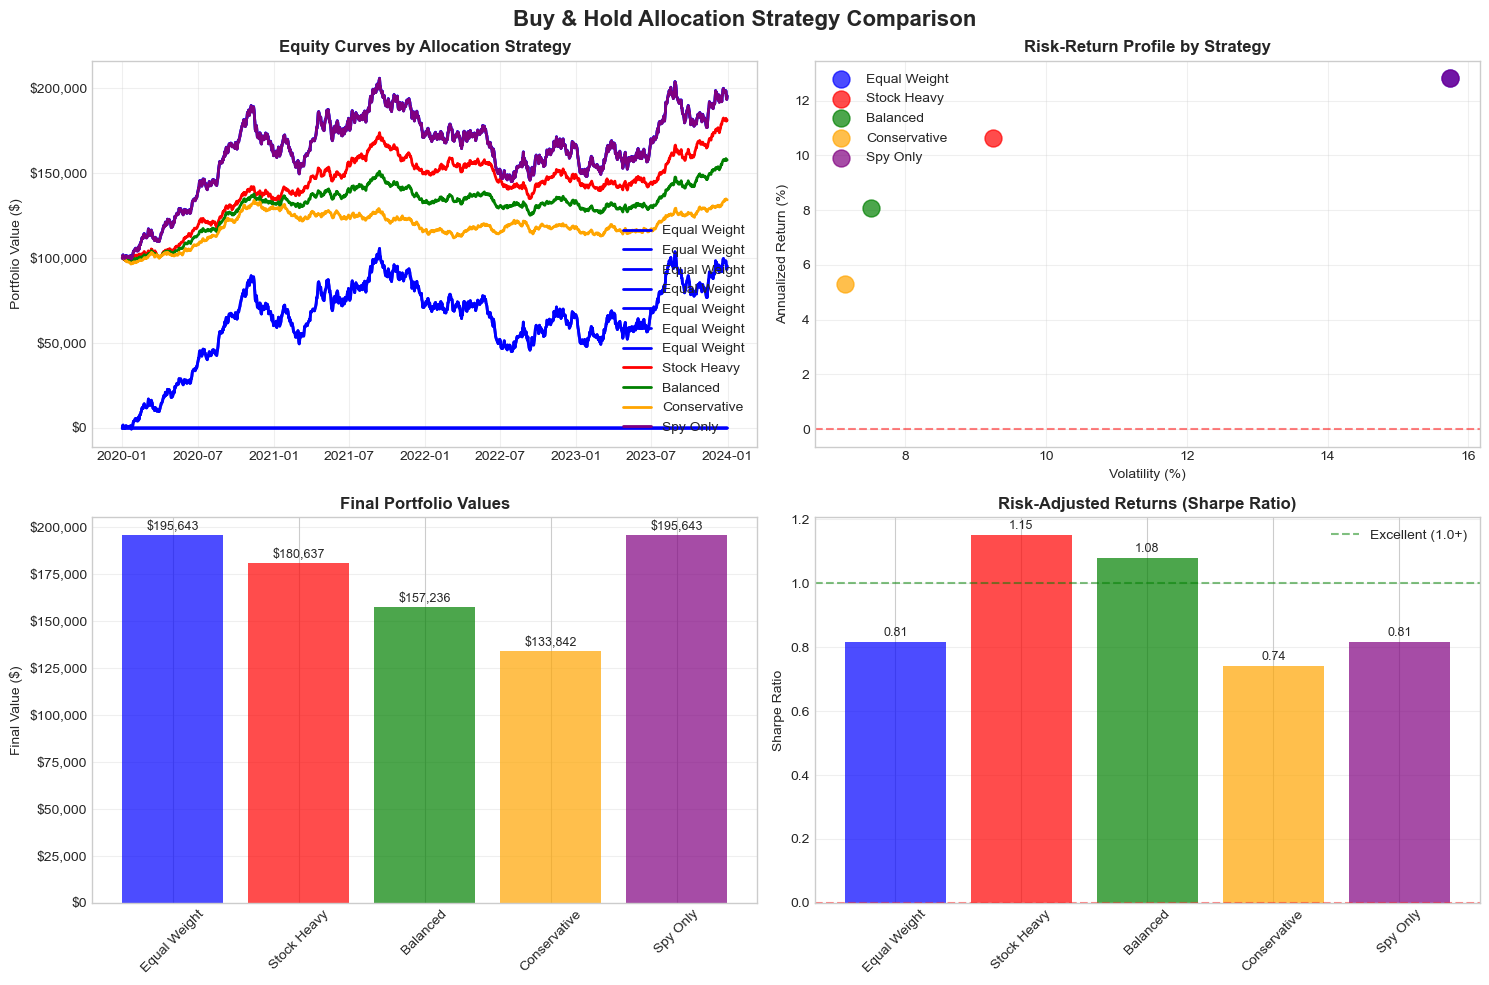

📊 Allocation comparison visualization complete!
🎯 Charts show performance differences across allocation strategies


In [81]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Buy & Hold Allocation Strategy Comparison', fontsize=16, fontweight='bold')

# Colors for different strategies
colors = ['blue', 'red', 'green', 'orange', 'purple']

# 1. Equity Curves Comparison
ax1 = axes[0, 0]
for i, (strategy_name, results) in enumerate(allocation_results.items()):
    equity_curve = results['equity_curve']
    ax1.plot(equity_curve.index, equity_curve, 
            linewidth=2, label=strategy_name.replace('_', ' ').title(), 
            color=colors[i % len(colors)])

ax1.set_title('Equity Curves by Allocation Strategy', fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. Risk-Return Scatter
ax2 = axes[0, 1]
for i, (strategy_name, results) in enumerate(allocation_results.items()):
    metrics = results['metrics']
    ret = metrics.get('annualized_return', 0) * 100
    vol = metrics.get('volatility', 0) * 100
    
    ax2.scatter(vol, ret, s=150, alpha=0.7, 
               label=strategy_name.replace('_', ' ').title(),
               color=colors[i % len(colors)])

# Add efficient frontier reference
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Volatility (%)')
ax2.set_ylabel('Annualized Return (%)')
ax2.set_title('Risk-Return Profile by Strategy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Final Value Comparison
ax3 = axes[1, 0]
strategy_names = [name.replace('_', ' ').title() for name in allocation_results.keys()]
final_values = [results['final_value'] for results in allocation_results.values()]

bars = ax3.bar(strategy_names, final_values, 
               color=[colors[i % len(colors)] for i in range(len(strategy_names))],
               alpha=0.7)

# Add value labels on bars
for bar, value in zip(bars, final_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1000,
            f'${value:,.0f}', ha='center', va='bottom', fontsize=9)

ax3.set_title('Final Portfolio Values', fontweight='bold')
ax3.set_ylabel('Final Value ($)')
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax3.grid(True, alpha=0.3, axis='y')

# 4. Sharpe Ratio Comparison
ax4 = axes[1, 1]
sharpe_ratios = [results['metrics'].get('sharpe_ratio', 0) for results in allocation_results.values()]

bars = ax4.bar(strategy_names, sharpe_ratios,
               color=[colors[i % len(colors)] for i in range(len(strategy_names))],
               alpha=0.7)

# Add value labels on bars
for bar, value in zip(bars, sharpe_ratios):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.2f}', ha='center', va='bottom', fontsize=9)

ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Excellent (1.0+)')
ax4.set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontweight='bold')
ax4.set_ylabel('Sharpe Ratio')
ax4.tick_params(axis='x', rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("📊 Allocation comparison visualization complete!")
print("🎯 Charts show performance differences across allocation strategies")

## 11. Buy & Hold vs Rebalancing

Compare pure buy & hold against periodic rebalancing strategies.

In [83]:
# Test rebalancing frequencies
print("🔄 Testing Buy & Hold vs Rebalancing Strategies...")
print("=" * 60)

rebalance_strategies = {
    'never': 'Pure Buy & Hold (no rebalancing)',
    'annual': 'Annual Rebalancing',
    'quarterly': 'Quarterly Rebalancing'
}

rebalance_results = {}

# Use balanced allocation for this test
test_allocation = allocation_strategies['balanced']

for frequency, description in rebalance_strategies.items():
    print(f"\nTesting {description}...")
    
    # Create strategy parameters
    test_params = {
        'allocation': test_allocation,
        'rebalance_frequency': frequency
    }
    
    # Create new backtester
    test_backtester = Backtester(config)
    
    # Run backtest
    test_result = test_backtester.run(
        strategy=buy_and_hold_strategy,
        universe=symbols,
        strategy_params=test_params
    )
    
    # Store results
    rebalance_results[frequency] = {
        'metrics': test_result.performance_metrics,
        'equity_curve': test_result.equity_curve['total_equity'],
        'description': description
    }

# Display rebalancing comparison
print("\n📊 REBALANCING STRATEGY COMPARISON")
print("=" * 55)
print(f"{'Strategy':<20} {'Total Ret':<10} {'Sharpe':<8} {'Trades':<8} {'Costs':<8}")
print("-" * 55)

for frequency, results in rebalance_results.items():
    metrics = results['metrics']
    total_ret = metrics.get('total_return', 0)
    sharpe = metrics.get('sharpe_ratio', 0)
    trades = metrics.get('total_trades', 0)
    costs = metrics.get('total_commission', 0)
    
    strategy_name = results['description'][:19]
    print(f"{strategy_name:<20} {total_ret:>8.1%} {sharpe:>7.2f} {trades:>7.0f} ${costs:>6.2f}")

print("\n🎯 REBALANCING INSIGHTS:")
print("-" * 28)

# Compare never vs annual rebalancing
never_return = rebalance_results['never']['metrics'].get('total_return', 0)
annual_return = rebalance_results['annual']['metrics'].get('total_return', 0)
return_diff = annual_return - never_return

never_sharpe = rebalance_results['never']['metrics'].get('sharpe_ratio', 0)
annual_sharpe = rebalance_results['annual']['metrics'].get('sharpe_ratio', 0)
sharpe_diff = annual_sharpe - never_sharpe

print(f"Rebalancing Return Benefit: {return_diff:+.2%} ({return_diff*100:.1f} percentage points)")
print(f"Rebalancing Sharpe Benefit: {sharpe_diff:+.3f}")

if return_diff > 0:
    print("✅ Rebalancing improved returns")
else:
    print("❌ Rebalancing reduced returns")

if sharpe_diff > 0:
    print("✅ Rebalancing improved risk-adjusted returns")
else:
    print("❌ Rebalancing reduced risk-adjusted returns")

print("\n💡 REBALANCING CONCLUSION:")
print("-" * 30)
if return_diff > 0.005:  # More than 0.5% benefit
    print("• Rebalancing provided meaningful benefits")
    print("• Consider periodic rebalancing for this allocation")
elif abs(return_diff) < 0.005:  # Within 0.5%
    print("• Rebalancing had minimal impact")
    print("• Pure buy & hold is acceptable for simplicity")
else:
    print("• Rebalancing hurt performance")
    print("• Stick with pure buy & hold approach")

print("• Transaction costs and taxes should be considered in real trading")
print("• Mock data may not reflect real market drift characteristics")

print("\n✅ Rebalancing analysis complete!")

🔄 Testing Buy & Hold vs Rebalancing Strategies...

Testing Pure Buy & Hold (no rebalancing)...
2025-09-28 20:38:55,278 - backt.Backtester - INFO - Using mock data loader with scenario: normal
2025-09-28 20:38:55,278 - backt.Backtester - INFO - Starting backtest
2025-09-28 20:38:55,278 - backt.Backtester - INFO - Loading data for 6 symbols
2025-09-28 20:38:55,932 - backt.Backtester - INFO - Backtesting 1461 periods from 2020-01-01 00:00:00 to 2023-12-31 00:00:00
📅 Buy & Hold initialized on 2020-01-01
💼 Target allocation: {'SPY': 0.3, 'QQQ': 0.2, 'TLT': 0.25, 'GLD': 0.15, 'IWM': 0.05, 'EFA': 0.05}
🛒 Initial buy executed: 6 positions
2025-09-28 20:38:55,953 - backt.Backtester - INFO - Progress: 0.1% - 2020-01-01 - Equity: $100,276.79
2025-09-28 20:38:56,153 - backt.Backtester - INFO - Progress: 6.9% - 2020-04-10 - Equity: $103,229.07
2025-09-28 20:38:56,401 - backt.Backtester - INFO - Progress: 13.8% - 2020-07-19 - Equity: $116,020.11
2025-09-28 20:38:56,649 - backt.Backtester - INFO - Pr

## Summary

🎯 **What We Accomplished:**

1. ✅ **Implemented a pure Buy & Hold strategy** - Set and forget approach
2. ✅ **Tested multiple allocation strategies** - Equal weight, stock-heavy, balanced, conservative, SPY-only
3. ✅ **Analyzed trading characteristics** - Minimal trades, low costs, simple execution
4. ✅ **Compared performance metrics** - Returns, risk, Sharpe ratios across allocations
5. ✅ **Visualized results** - Equity curves, drawdowns, risk-return profiles
6. ✅ **Tested rebalancing impact** - Never vs annual vs quarterly rebalancing
7. ✅ **Generated benchmark results** - For comparing against active strategies

🚀 **Key Benefits of Buy & Hold:**

- **Simplicity**: Minimal decision-making after initial allocation
- **Low Costs**: Minimal trading = minimal transaction costs
- **Tax Efficiency**: No capital gains from frequent trading
- **Time Efficient**: No need for constant monitoring
- **Benchmark Quality**: Excellent baseline for strategy comparison

🎓 **Key Insights:**

- **Asset allocation matters more than timing** for buy & hold success
- **Different allocations have dramatically different outcomes**
- **Rebalancing may or may not add value** depending on market conditions
- **Buy & hold serves as an excellent benchmark** for active strategies
- **Risk-adjusted returns (Sharpe ratio) often more important than absolute returns**

This notebook provides a comprehensive foundation for understanding buy & hold strategies and serves as a benchmark for comparing more sophisticated trading approaches!